# Segmentation 

This notebook shows how to use Stardist (Object Detection with Star-convex Shapes) as a part of a segmentation-classification-tracking analysis pipeline. 

The sections of this notebook are as follows:

1. Load images
2. Load model of choice and segment an initial image to test Stardist parameters
3. Batch segment a sequence of images

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

This notebook uses the dask octopuslite image loader from the CellX/Lowe lab project.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from octopuslite import DaskOctopusLiteLoader
from stardist.models import StarDist2D 
from stardist.plot import render_label
from csbdeep.utils import normalize
from tqdm import tqdm
from skimage.io import imsave
import json

## 1. Load images

In [3]:
# define experiment ID and select a position
expt = 'ND0006'
pos = 'Pos10'
image_path = f'/home/nathan/data/kraken/ras/{expt}/{pos}/{pos}_aligned'
images = DaskOctopusLiteLoader(image_path)

Using cropping: None


## 2. Load model and test segment single image 

In [4]:
model = StarDist2D(None, name='stardist_multiclass_MDCK', basedir='models')
model

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.552369, nms_thresh=0.3.


StarDist2D(stardist_multiclass_MDCK): YXC → YXC
├─ Directory: /home/nathan/analysis/segment-classify-track/models/stardist_multiclass_MDCK
└─ Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=2, n_channel_out=33, n_classes=2, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 2], net_mask_shape=[None, None, 1], train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=[1, 1, 1], train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=[1, 0.2, 1], train_n_val_patches=None, train_patch_size=[256, 256], train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_ke

In [6]:
# set test image index
frame = 100
# load test image 
gfp = images['gfp'][frame]
rfp = images['rfp'][frame]
# create 2-channel image
img = np.zeros((gfp.shape[0], gfp.shape[1] ,2), dtype = 'uint8') 
img[:,:,0] = gfp
img[:,:,1] = rfp
img.shape

(1352, 1688, 2)

### 2.1 Test run and display initial results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


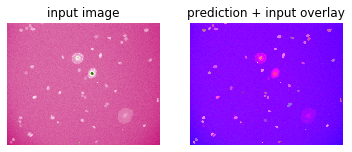

In [7]:
# initialise test segmentation
labels, details = model.predict_instances(normalize(img))

# plot input image and prediction
plt.clf()
plt.subplot(1,2,1)
plt.imshow(normalize(img[:,:,0]), cmap="PiYG")
plt.axis("off")
plt.title("input image")
plt.subplot(1,2,2)
plt.imshow(render_label(labels, img = img))
plt.axis("off")
plt.title("prediction + input overlay")
plt.show()

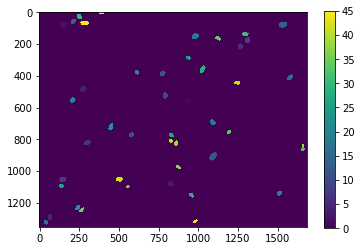

In [8]:
plt.imshow(labels)
plt.colorbar()
plt.show()

## 3. Batch segment a whole stack of images

In [ ]:
%%time
for expt, pos in zip(['ND0006'], ['Pos10']):
    print('Starting experiment position:', expt, pos)
    # load images
    image_path = f'/home/nathan/data/kraken/ras/{expt}/{pos}/{pos}_aligned'
    images = DaskOctopusLiteLoader(image_path)
    # set output directory for segmented images
    if not os.path.exists(image_path.replace('aligned', 'stardist_masks')):
        os.mkdir(image_path.replace('_aligned', '_stardist_masks'))
    for frame in tqdm(range(len(images['gfp'])), position=0, leave=True):
        # compile 2-channels into XYC array
        img = np.zeros((images['gfp'][frame].shape[0], images['gfp'][frame].shape[1], 2)) 
        img[:,:,0] = images['gfp'][frame]
        img[:,:,1] = images['rfp'][frame]
        # predict labels using 2ch image
        labels, details = model.predict_instances(normalize(img))
        # set filename as mask format (channel099)
        fn = ((images.files('gfp')[frame].replace('_aligned', '_stardist_masks')).replace('.tif', '_stardist_masks.tif')).replace('channel001', 'channel099')
        # save out labelled image
        imsave(fn, labels.astype(np.uint16), check_contrast=False)
        # save out details array ## need to work on this to finesse
        fn = fn.replace('.tif', '_details.npz')
        np.savez(fn, details)

Starting experiment position: ND0006 Pos10
Using cropping: None


  1%|          | 5/859 [00:08<23:44,  1.67s/it]